In [122]:
# Experiment Parameters

# Experiment conditions
use_all_rewriter_rules = True
convert_bigraph = True
not_representation = "X"
not_placement = "end"
gate_layers = ["H", "Rx"]

# load params
train_params = True
load_params = False
spsa_a = 0.2
spsa_c = 0.06
spsa_n_iter = 5

# SVM type
kernel = 'rbf'
default_svm = True
optimize_svm = False

# Experiment metadata
experiment_name = "code_test"
verbose = True

# Experiment parameters format:
#    dataset | gate_layers | var_layers | spsa_a | spsa_c | spsa_n_iter | parameterize_nouns
#     (str)  | ([str, str])| (int:0..2) | (float)| (float)|    (int)    |       (bool)

experiments = [
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 130, True],
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 200, True],
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 500, True],
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 130, False],
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 200, False],
    ["restaurant_v5", ["H", "Rx"], 1, 0.2, 0.06, 500, False],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 130, True],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 200, True],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 500, True],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 130, False],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 200, False],
    ["restaurant_v5", ["H", "Ry"], 1, 0.2, 0.06, 500, False],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 130, True],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 200, True],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 500, True],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 130, False],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 200, False],
    ["restaurant_v5", ["Rx", "Ry"], 2, 0.2, 0.06, 500, False],

]

In [123]:
import os
import json

if (experiment_name == ""):
    experiment_name = "misc"

path = '../data/experiment_results/generalQC/'+experiment_name

try:
    os.mkdir(path)
except:
    print("experiment folder already exists")

experiment folder already exists


In [124]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

In [125]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [126]:
# try:
#     with open(path+'/params.txt') as f:
#         data = f.read().replace('\'', '\"')
#         params_saved = json.loads(data)
# except:
#     params_saved = None
#     train_params = False

In [127]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences

test_targets_src, test_data_src = read_data('../data/datasets/restaurant_v3_test.txt')
dev_targets_src, dev_data_src = read_data('../data/datasets/restaurant_v3_dev.txt')
train_targets_src, train_data_src = read_data('../data/datasets/restaurant_v3_train.txt')

In [128]:
# Helper function for converting to bigraph

from discopy.rigid import Id as RigidId

def checkTrailingCups(diagram):
    scanWords = True
    
    for box in diagram.boxes:
        if not box.dom and not scanWords:
            return False
        else:
            scanWords = scanWords and not box.dom
    
    return True

def convertToTrailingCups(diagram):
    if (checkTrailingCups(diagram)):
        return diagram

    words = []
    cups = []
    
    for box in diagram.boxes:
        if not box.dom:
            words = words + [box]
        else:
            cups = [box] + cups
    
    new_diag = words[0]
    
    for i, word in enumerate(words):
        if i != 0:
            new_diag = new_diag >> RigidId(new_diag.cod) @ word
    
    for i, cup in enumerate(cups):
        if i != len(cups)-1:
            new_diag = new_diag >> RigidId(new_diag.cod[:-2]) @ cup
        else:
            new_diag = new_diag >> cup @ RigidId(new_diag.cod[2:])
    
    return new_diag

In [129]:
# Fucntion for stemming and lemmatization of tokens

def to_word_tokens(data):
    return [word_tokenize(record) for record in data]

def build_stem_dictionary(data):
    port = PorterStemmer()
    wnet = WordNetLemmatizer()
    
    mapping = {}
    
    data_as_tokens = to_word_tokens(data)
    
    for words in data_as_tokens:
        for word in words:
            if word not in mapping:
                stemmed_word = port.stem(word)
                lemmatized_word = wnet.lemmatize(stemmed_word)
                
                mapping[word] = lemmatized_word
    
    return mapping

In [130]:
# Function for stemming and lemmatization of diagram boxes

from lambeq.rewrite import RewriteRule

class StemRewriteRule(RewriteRule):
    def __init__(self, data):
        self.mapping = build_stem_dictionary(data)
    
    def matches(self, box):
        return box.name in self.mapping

    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, dom=box.dom, cod=box.cod)

In [131]:
from lambeq.ansatz import CircuitAnsatz
from abc import abstractmethod
# from collections.abc import Mapping
from itertools import cycle
from typing import Callable, Optional, Tuple, Mapping
from discopy.quantum.circuit import (Circuit, Functor, Id, qubit)
from discopy.quantum.gates import Bra, Ket, Controlled, Rotation
from discopy.quantum.gates import H, X, Y, Z, Rx, Ry, Rz
from discopy.rigid import Box, Diagram, Ty
from discopy.tensor import Dim, Tensor
import numpy as np
from sympy import Symbol, symbols

class GeneralQCLayer(Circuit):
    
    def __init__(self, n_qubits, params):
        from discopy.quantum.gates import Rx, Rz

        if len(self.gate_layers) != 2:
            raise ValueError("Expected gate_layers as tuple of strings")
        
        g1, g2 = self.gate_layers

        if (g1 == None) or (g2 == None):
            raise ValueError("gate_layers must be in discopy.quantum.gates")
        # if not (abs(self.r1) == 1 and abs(self.r2) == 1) and ((abs(self.r1) == 1 or abs(self.r2) == 1) and (self.r2 % self.r1 == 0 or self.r1 % self.r2 == 0)) or (n_qubits % self.r1 == 0 and self.r1 != 1) or (n_qubits % self.r2 == 0 and self.r2 != 1):
        #     raise ValueError("n_qubits, r1, and r2 must be co-prime")

        params_shape = np.shape(params)

        if n_qubits == 1:
            if len(params) == 0:
                circuit = Id(1)
            else:
                circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
        elif (len(params_shape) != 2):
            raise ValueError(
                "Expected params of shape (depth, {})".format(n_qubits))
        else:
            g1_thetas = 0
            g2_thetas = 0

            if g1.free_symbols != {}:
                # g1 is fixed
                g1_thetas = n_qubits
            if g2.free_symbols != {}:
                g2_thetas = n_qubits

            if self.reuse_params:
                self.k = 1
            else:
                self.k = 2
            
            n_thetas = self.k*(g1_thetas + g2_thetas)

            if (params_shape[1] != n_thetas):
                raise ValueError(
                    "Expected component params with length {}".format(n_thetas))

            # ANSATZ ALGORITHM
            circuit = Id(n_qubits)
            
            # for {theta} in labelled params
            for thetas in params:
                
                # sublayer 1 non-entangling block
                if g1_thetas == 0:
                    # if g1 is fixed
                    sublayer1 = Id().tensor(*([g1 for _ in range(n_qubits)]))
                else:
                    # if g1 is trainable
                    sublayer1 = Id().tensor(*([g1(theta) for theta in thetas[:g1_thetas]]))
                
                # sublayer 1 entangled block
                ctrl = 0

                for i in range(n_qubits):
                    # shift target := control - r1
                    tgt = (ctrl - self.r1) % n_qubits
                    
                    if g2_thetas == 0:
                        sublayer1 = sublayer1._apply_controlled(g2, ctrl, tgt)
                        # sublayer1 = sublayer1.CX(ctrl, tgt)
                    else:
                        sublayer1 = sublayer1._apply_controlled(g2(thetas[g1_thetas + i]), ctrl, tgt)
                        # sublayer1 = sublayer1.CRx(thetas[g1_thetas + i], ctrl, tgt)
                    
                    ctrl = tgt
                
                # sublayer 2 non-entangling block
                if g1_thetas == 0:
                    sublayer2 = Id().tensor(*([g1 for _ in range(n_qubits)]))
                else:
                    if self.reuse_params:
                        sublayer2 = Id().tensor(*([g1(theta) for theta in thetas[:g1_thetas]]))
                    else:
                        sublayer2 = Id().tensor(*([g1(theta) for theta in thetas[g1_thetas+g2_thetas:2*g1_thetas+g2_thetas]]))
                
                # sublayer 2 entangled block
                ctrl = 0

                for i in range(n_qubits):
                    # shift target := control - r2
                    tgt = (ctrl - self.r2) % n_qubits

                    if g2_thetas == 0:
                        sublayer2 = sublayer2._apply_controlled(g2, ctrl, tgt)
                        # sublayer2 = sublayer2.CX(ctrl, tgt)
                    else:
                        if self.reuse_params:
                            sublayer2 = sublayer2._apply_controlled(g2(thetas[g1_thetas + i]), ctrl, tgt)
                        else:
                            sublayer2 = sublayer2._apply_controlled(g2(thetas[2*g1_thetas+g2_thetas+i]), ctrl, tgt)
                            # sublayer2 = sublayer2.CRx(thetas[2*g1_thetas+g2_thetas+i], ctrl, tgt)
                    
                    ctrl = tgt
            
                # compose circuit
                circuit >>= sublayer1 >> sublayer2
            
        super().__init__(
            circuit.dom, circuit.cod, circuit.boxes, circuit.offsets)

class GeneralQCAnsatz(CircuitAnsatz):
    def __init__(self, ob_map: Mapping[Ty, int], n_layers: int, n_single_qubit_params: int = 0, gate_config = {"gate_layers": [H, Rx], "var_layers": 1}, r = (1, 3), reuse_params=True, discard: bool = False) -> None:
        self.gate_config = gate_config
        self.reuse_params = reuse_params
        self.r = r
        
        class GeneralQCInterface(GeneralQCLayer):
            """ Interface for GeneralQCLayer """

            def strToGate(gateStr):
                if gateStr == "H":
                    return H
                if gateStr == "X":
                    return X
                if gateStr == "Y":
                    return Y
                if gateStr == "Z":
                    return Z
                if gateStr == "Rx":
                    return Rx
                if gateStr == "Ry":
                    return Ry
                if gateStr == "Rz":
                    return Rz
                
                return Id(1)
            
            assert(len(self.gate_config["gate_layers"]) == 2)

            g1, g2 = self.gate_config["gate_layers"]

            if isinstance(g1, str):
                g1 = strToGate(g1)
            if isinstance(g2, str):
                g2 = strToGate(g2)

            gate_layers = [g1, g2]
            r1, r2 = self.r
            reuse_params = self.reuse_params

        super().__init__(ob_map, n_layers, n_single_qubit_params, GeneralQCInterface, discard, [Rx, Rz])

    def params_shape(self, n_qubits: int) -> Tuple[int, ...]:
        if self.reuse_params:
            k = 1
        else:
            k = 2
        
        return (self.n_layers, k*self.gate_config["var_layers"]*n_qubits)

In [132]:
from lambeq import BobcatParser, Rewriter, remove_cups
from discopy import grammar
from discopy.quantum.gates import X, Z
from discopy import rigid

def sentences_to_circuits(sentences, ansatz, convert_bigraph=True, not_representation="X", all_sentences=None, return_valids_mask=True):
    ### SENTENCES TO DIAGRAMS ###

    if all_sentences is None:
        all_sentences = sentences
    
    # syntax tree parsing
    parser = BobcatParser()
    raw_diagrams = parser.sentences2diagrams([text.replace(" not ", " ") for text in sentences])

    # filter valid diagrams type S
    n_sent = len(sentences)

    valids_mask = np.array([d.cod.name == Ty('s').name for d in raw_diagrams])
    data = [sentences[i] for i in range(n_sent) if valids_mask[i]]
    use_diagrams = [raw_diagrams[i] for i in range(n_sent) if valids_mask[i]]

    # grammatical rewrite rules
    rewriter = Rewriter()
    rewritten_diagrams = [rewriter(diagram) for diagram in use_diagrams]

    # bigraph method
    normalised_diagrams = [convertToTrailingCups(diagram.normal_form()) for diagram in rewritten_diagrams]

    removed_diagrams = [remove_cups(diagram) for diagram in normalised_diagrams]

    # stemming and lemmatization
    stemmed_diagrams = [Rewriter([StemRewriteRule(all_sentences)])(diagram) for diagram in removed_diagrams]

    # final diagrams
    diagrams = [diagram for diagram in stemmed_diagrams]

    ### DIAGRAMS to CIRCUITS ###

    # string diagrams to raw quantum circuits
    circuits = [ansatz(diagram) for diagram in diagrams]

    # apply NOT box to circuits
    for i, circuit in enumerate(circuits):
        if data[i].find(" not ") != -1:
            if (not_representation == "ZX"):
                circuits[i] = circuit >> Z >> X
            else:
                circuits[i] = circuit >> X
    
    if return_valids_mask:
        return data, diagrams, circuits, valids_mask
    else:
        return data, diagrams, circuits

In [133]:
from lambeq import AtomicType, IQPAnsatz
from discopy.quantum.gates import H, X, Y, Z, Rx, Ry, Rz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = GeneralQCAnsatz({N: 1, S: 1}, n_layers=1, n_single_qubit_params=0, gate_config={"gate_layers": ["Rx", "X"], "var_layers": 1}, r=(1, -1))


In [134]:
train_data, train_diagrams, train_circuits, train_valids_mask = sentences_to_circuits(train_data_src, ansatz)
dev_data, dev_diagrams, dev_circuits, dev_valids_mask = sentences_to_circuits(dev_data_src, ansatz)
test_data, test_diagrams, test_circuits, test_valids_mask = sentences_to_circuits(test_data_src, ansatz)

Tagging sentences:   0%|          | 0/43 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/170 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/170 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/13 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/50 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/50 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/15 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/60 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/60 [00:00<?, ?it/s]

In [135]:
train_targets = [train_targets_src[i] for i, mask in enumerate(train_valids_mask) if mask]
dev_targets = [dev_targets_src[i] for i, mask in enumerate(dev_valids_mask) if mask]
test_targets = [test_targets_src[i] for i, mask in enumerate(test_valids_mask) if mask]

In [136]:
from pytket.extensions.qiskit import AerBackend

In [137]:
# configure backend
backend = AerBackend()

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 8192  # maximum recommended shots, reduces sampling error
}

In [138]:
from discopy.quantum import Circuit, Id, Measure

def randint(rng, low=-1 << 63, high=1 << 63-1):
    return rng.integers(low, high)

def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()

def make_pred_fn(circuits, parameters, rng):
    measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
    circuit_fns = [c.lambdify(*parameters) for c in measured_circuits]

    def predict(params):
        outputs = Circuit.eval(*(c_fn(*params) for c_fn in circuit_fns),
                               **backend_config, seed=randint(rng))
        return np.array([normalise(output.array) for output in outputs])
    return predict

In [139]:
from noisyopt import OptimizeResult

def myMinimizeSPSA(func, x0, args=(), bounds=None, niter=100, paired=True,
                 a=1.0, c=1.0, k0=0,
                 disp=False, callback=None):
    """
    Minimization of an objective function by a simultaneous perturbation
    stochastic approximation algorithm.

    Parameters
    ----------
    func: callable
        objective function to be minimized
    x0: array-like
        starting point
    args: tuple
        extra arguments to be supplied to func
    bounds: array-like
        bounds on the variables
    scaling: array-like
        scaling by which to multiply step size and tolerances along different dimensions
    niter: int
        maximum number of iterations of the algorithm
    paired: boolean
        calculate gradient for same random seeds
    a: float
       algorithm scaling parameter for step size
    c: float
       algorithm scaling parameter for evaluation step size
    disp: boolean
        whether to output status updates during the optimization
    callback: callable
        called after each iteration, as callback(xk), where xk is the current parameter vector.

    Returns
    -------
    scipy.optimize.OptimizeResult object
    """
    A = 0.01 * niter
    alpha = 0.602
    gamma = 0.101

    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])

    if args is not None:
        # freeze function arguments
        def funcf(x, **kwargs):
            return func(x, *args, **kwargs)

    N = len(x0)
    x = x0
    for k in range(k0, niter):
        ak = a/(k+1.0+A)**alpha
        ck = c/(k+1.0)**gamma
        delta = np.random.choice([-1, 1], size=N)
        fkwargs = dict()
        if paired:
            fkwargs['seed'] = np.random.randint(0, np.iinfo(np.uint32).max, dtype=np.int64)
        if bounds is None:
            grad = (funcf(x + ck*delta, **fkwargs) - funcf(x - ck*delta, **fkwargs)) / (2*ck*delta)
        else:
            # ensure evaluation points are feasible
            xplus = project(x + ck*delta)
            xminus = project(x - ck*delta)
            grad = (funcf(xplus, **fkwargs) - funcf(xminus, **fkwargs)) / (xplus-xminus)
        x = project(x - ak*grad)
        # print 100 status updates if disp=True
        if disp and (k % (niter//100)) == 0:
            print(x)
        if callback is not None:
            callback(x)
    message = 'terminated after reaching max number of iterations'
    return OptimizeResult(fun=funcf(x), x=x, nit=niter, nfev=2*niter, message=message, success=True)

In [140]:
from noisyopt import minimizeSPSA
import time
import csv
import matplotlib.pyplot as plt
from sympy import default_sort_key
import gc

class Result:
    def __init__(self, x):
        self.x = x

def make_cost_fn(pred_fn, labels, directory, name):
    if name == "test":
        with open(f'{directory}/{name}_costs.csv', 'w') as f:
            pass
    
    if name == "test":
        with open(f'{directory}/{name}_accs.csv', 'w') as f:
            pass

    if name == "test":
        with open(f'{directory}/params_raw.txt', 'w') as f:
            pass
    
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        
        with open(f'{directory}/{name}_costs.csv', 'a', newline='') as f:
            writer = csv.writer(f)

            writer.writerow([cost])

            f.close()

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        
        with open(f'{directory}/{name}_accs.csv', 'a', newline='') as f:
            writer = csv.writer(f)

            writer.writerow([acc])

            f.close()
        
        with open(f'{directory}/params_raw.txt', 'w', newline='') as f:
            paramstr = "["
            
            for e in params:
                paramstr += str(e) + ", "

            paramstr = paramstr[:-2] + "]"

            f.write(paramstr)
        
        if name == "dev":
            gc.collect()

        return cost

    return cost_fn

def run_circuit_optimization(train_circuits, train_targets, dev_circuits, dev_targets, test_circuits, test_targets, experiment_name, train_params=True, load_params=False, params_saved=[], spsa_n_iter=spsa_n_iter):
    # collect params
    all_circuits = train_circuits + dev_circuits + test_circuits

    # sort the symbols since they are returned as a set
    parameters = sorted(
        {s for circ in all_circuits for s in circ.free_symbols},
        key=default_sort_key)
    
    # make prediction and cost functions

    SEED = 0
    rng = np.random.default_rng(SEED)

    train_pred_fn = make_pred_fn(train_circuits, parameters, rng)
    dev_pred_fn = make_pred_fn(dev_circuits, parameters, rng)
    test_pred_fn = make_pred_fn(test_circuits, parameters, rng)

    train_cost_fn = make_cost_fn(train_pred_fn, train_targets, '../data/experiment_results/generalQC/'+experiment_name, 'train')
    dev_cost_fn = make_cost_fn(dev_pred_fn, dev_targets, '../data/experiment_results/generalQC/'+experiment_name, 'dev')

    if (load_params):
        # load params

        # x0 = [params_saved[str(param)] for param in parameters]
        x0 = params_saved
        result = Result(x0)
    else:
        x0 = np.array(rng.random(len(parameters)))
        np.random.seed(SEED)

    # train params using SPSA
    
    start_time = time.time()
    # result = minimizeSPSA(train_cost_fn, x0=x0, a=spsa_a, c=spsa_c, niter=10, callback=dev_cost_fn)
    if train_params:
        result = myMinimizeSPSA(train_cost_fn, x0=x0, a=spsa_a, c=spsa_c, k0=0, niter=spsa_n_iter, callback=dev_cost_fn)
        print("trained params")
    else:
        result = Result(x0)
    
    finish_time = time.time()

    with open(f'../data/experiment_results/generalQC/{experiment_name}/fit_time.txt', 'w') as f:
        f.write(str(finish_time-start_time))

    train_costs = []
    train_accs = []
    dev_costs = []
    dev_accs = []

    with open(f'../data/experiment_results/generalQC/{experiment_name}/train_costs.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            train_costs.append(float(row[0]))

    with open(f'../data/experiment_results/generalQC/{experiment_name}/train_accs.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            train_accs.append(float(row[0]))

    with open(f'../data/experiment_results/generalQC/{experiment_name}/dev_costs.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            dev_costs.append(float(row[0]))

    with open(f'../data/experiment_results/generalQC/{experiment_name}/dev_accs.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            dev_accs.append(float(row[0]))

    if train_params:
        print("Fit time:", finish_time-start_time)
        
        fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
        ax_tl.set_title('Training set')
        ax_tr.set_title('Development set')
        ax_bl.set_xlabel('Iterations')
        ax_br.set_xlabel('Iterations')
        ax_bl.set_ylabel('Accuracy')
        ax_tl.set_ylabel('Loss')

        colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
        ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
        ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
        ax_tr.plot(dev_costs, color=next(colours))
        ax_br.plot(dev_accs, color=next(colours))

    # print test accuracy
    test_cost_fn = make_cost_fn(test_pred_fn, test_targets, '../data/experiment_results/generalQC/'+experiment_name, 'test')
    test_cost_fn(result.x)

    with open(f'../data/experiment_results/generalQC/{experiment_name}/test_accs.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            print('Test accuracy:', row[0])
            test_accs = [row[0]]
            break
    
    paramdict = {}
    paramdict_print = {}

    for value, parameter in zip(result.x, parameters):
        paramdict[parameter] = value
        paramdict_print[str(parameter)] = value

    with open('../data/experiment_results/generalQC/'+experiment_name+'/params.txt', 'w') as f:
        f.write(str(paramdict_print))

    # print(paramdict_print)

    opt_results = {
        "params": {
            "parameters": parameters, 
            "x": result.x
            }, 
        "train": {
            "pred_fn": train_pred_fn, 
            "cost_fn": train_cost_fn, 
            "accs": train_accs[1::2], 
            "costs": train_costs[1::2]
            }, 
        "dev": {
            "pred_fn": dev_pred_fn, 
            "cost_fn": dev_cost_fn, 
            "accs": dev_accs, 
            "costs": dev_costs
            }, 
        "test": {
            "pred_fn": test_pred_fn, 
            "cost_fn": test_cost_fn, 
            "accs": test_accs, 
            "costs": None
            }
        }

    return opt_results

trained params
Fit time: 605.8298530578613
Test accuracy: 0.5


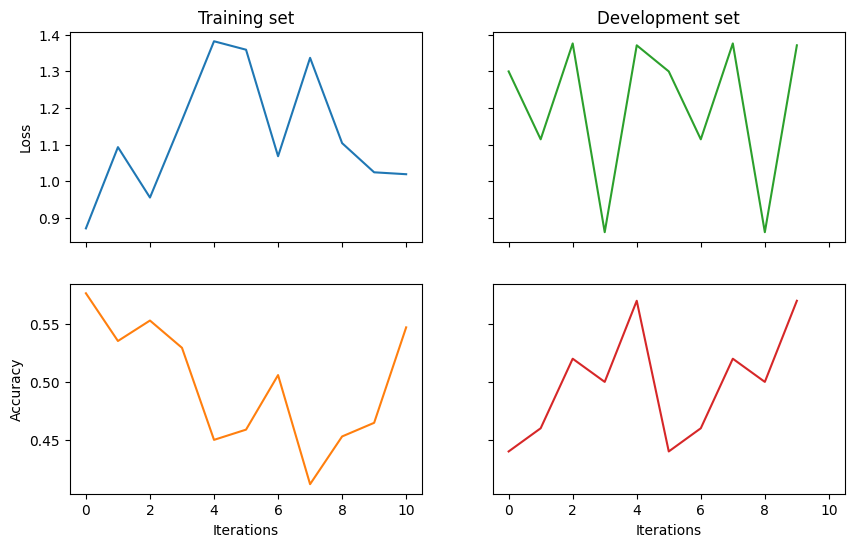

In [141]:
opt_results = run_circuit_optimization(train_circuits, train_targets, dev_circuits, dev_targets, test_circuits, test_targets, experiment_name, train_params, load_params, params_saved=param_vals)

train_pred_fn, train_cost_fn, train_accs, train_costs = list(opt_results["train"].values())
dev_pred_fn, dev_cost_fn, dev_accs, dev_costs = list(opt_results["dev"].values())
test_pred_fn, test_cost_fn, test_accs, test_costs = list(opt_results["test"].values())
parameters, x = list(opt_results["params"].values())